---
# 03_training_and_evaluation.ipynb
---

This notebook provides a complete end-to-end example of how to train and evaluate a model using the `ModularML` framework. It demonstrates how to:

1. Define a `ModelGraph` with one or more trainable model stages
2. Wrap training logic in a `TrainingPhase`
3. Run training using the `Experiment` container
4. Evaluate the trained model using `EvaluationPhase`
5. Visualize predictions against ground truth

We use a simple example in which a fully connected MLP regressor is trained to estimate target values from pulse charge features of a battery dataset.

We will be utilizing the FeatureSet and ModelStages created in the prior two notebooks. 
If you haven't already, please go through the following examples:
* [01_featureset_basics.ipynb](./01_featureset_basics.ipynb)
* [02_modelgraph_basics.ipynb](./02_modelgraph_basics.ipynb)


Let's reload the pre-processed FeatureSet and ModelStages.


In [1]:
from modularml.core import FeatureSet, ModelStage, ModelGraph, Optimizer
from modularml.models import SequentialCNN, SequentialMLP
import modularml as mml

from pathlib import Path

FILE_FEATURE_SET = Path("downloaded_data/charge_samples.joblib")
charge_samples = FeatureSet.load(FILE_FEATURE_SET)
charge_samples

FeatureSet(label='ChargePulseFeatures', n_samples=12024)

We will start this example with a simple 3-layer MLP model.
It pulls features from the 'ChargePulseFeatures' FeatureSet.

We can confirm the target output size with `FeatureSet.target_shape`

In [2]:
print(charge_samples.target_shape)

ms_regressor = ModelStage(
    model=SequentialMLP(output_shape=(1, 1), n_layers=3, hidden_dim=16),
    label='Regressor',
    inputs='ChargePulseFeatures',  		# Input from feature set
    optimizer=Optimizer(name='adam', backend=mml.Backend.TORCH)
)

(1, 1)


The ModelGraph is constructed via a list of ModelStages and FeatureSets.

Calling `build_all` ensure all ModelStages instantiate their underlying NN components, and infer any missing input/output shapes. 

Inferred shapes for `Regressor`:  (1, 101) -> (1, 1)


(<Figure size 600x300 with 1 Axes>, <Axes: >)

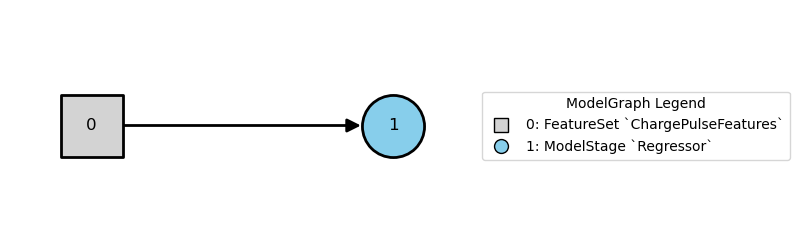

In [3]:
mg = ModelGraph(nodes=[charge_samples, ms_regressor])
mg.build_all()
mg.visualize()

Now that the `ModelGraph` is built, we are ready to move on to the core ModularML training logic and central `Experiment` container.

## Define a Training Phase

Training in ModularML is handled through a `TrainingPhase`. It is a declarative container that defines how to train the ModelGraph.

If has the following initiallization arguments:
* `label`: a name (str) to assigned to this training phase for logging (e.g., "pretrain_encoder").
* `losses`: a list of `AppliedLoss` objects
* `samplers`: a mapping of `FeatureSampler`s to FeatureSets in ModelGraph.
* `batch_size`: the batch size to use across all batches in a single training phase.
* `n_epochs`: the number of training epochs.



Let's start with the `AppliedLoss` class.
It defines the loss function and how it should be applied to the ModelGraph.

For example, let's assume we are using a TripletSampler, which produces 'anchor', 'positive', and 'negative' sample pairs.
We would have a corresponding TripletLoss that takes in the ModelStage outputs for each of these sample roles. 

``` python
def triplet_loss(anchor, positive, negative): ...
```

To apply this triplet_loss to a ModelStage's output (assume it's called 'encoder'), we would define an AppliedLoss where the `inputs` argument maps the loss function keyword arguments to the available samples and roles.


``` python
ap = AppliedLoss(
	label='my_triplet_loss',
	loss=Loss(loss_function=triplet_loss),
	inputs={
		'anchor': "ChargePulseFeatures.features.anchor",
		'positive': "ChargePulseFeatures.features.negative",
		'negative': "ChargePulseFeatures.features.positive",
	}
)
```

The `inputs` key-value following the following schema: 
* the key must be a keyword argument of the loss_function. If the loss function only accepts positional arguments, keys can take the form of integers or string equivalents (e.g., `{"0": ..., }` or `{0: ..., }`)
* the value is a period (.)-parsed string with the following pattern: `'node.attribute.role'`:
  * `node` is the label of a FeatureSet or ModelStage contained in ModelGraph
  * `attribute` is one of the following: ['features',  'targets', 'output']
    * 'features' and 'targets' only apply if `node` is a FeatureSet
    * 'output' is used if `node` is a ModelStage
  * `role` is a sample key defined by the FeatureSampler used. E.g, a TripletSampler creates 'anchor', 'positive', and 'negative' roles. A simple FeatureSampler has only a 'default' role. If `role` is ommited (e.g., `'node.attribute'`), then the role is assumed to be 'default'.

For our first example, we only have a single MLP ModelStage where our task is estimating battery state-of-health. 

We will start with only a single mean-squared-error loss function applied to the regressor outputs.
Common loss functions are easily accessible using the `name` and `backend` attribute of the `Loss` class.
See the documentation for a more detailed description on available losses.

In [4]:
from modularml.core import AppliedLoss, Loss

mse_loss = AppliedLoss(
    label='MyAppliedLoss',
	loss=Loss(name='mse', backend=mml.Backend.TORCH),
	inputs={		# The PyTorch MSELoss only accept positional arguments
		"0": "ChargePulseFeatures.targets",
		"1": "Regressor.output"
	},
)

The next set of `TrainingPhase` attributes define the sampling configuration.

Since we only have one FeatureSet (`"ChargePulseFeatures"`) in our ModelGraph, we only need to create one FeatureSampler.
Our `mse_loss` only need a single sample role ("default"), so we can stick with just a simple FeatureSampler.

In [5]:
from modularml.core import FeatureSampler

sampler = FeatureSampler(
	shuffle=True,
	stratify_by=["pulse_soc"],
 	seed=13
)

The base `FeatureSampler` support grouping and stratification via the `group_by` and `stratify_by` parameters.

Using `stratify_by=["pulse_soc"]` ensures that every batch created from the feature set contains an equal distribution of pulse states of charge (SOC).   

Attaching the sampler to `TrainingPhase` is done with a key:value entry in a dictionary. 
The key must be the name of FeatureSet or FeatureSubset (e.g., 'ChargePulseFeatures' or 'ChargePulseFeatures.train')

In [6]:
from modularml.core import TrainingPhase

phase1 = TrainingPhase(
	label="train_phase",
	losses=[mse_loss, ],
	samplers={'ChargePulseFeatures.train': sampler},
	batch_size=32,
	n_epochs=50
)

We now have a fully-configured TrainingPhase, that utilizes the 'train' subset of the 'ChargePulseFeatures' FeatureSet.
An MSE loss is applied to the single MLP regressor ModelStage.

## Create and Run the Experiment

The `Experiment` container manages both training and evaluation phases. 
It takes a `ModelGraph` and one or more phases (training or evaluation).

Calling `.run()` will automatically execute all training phases and manage phase-level loss computation, sampling, and optimizer stepping.

In [7]:
# Initialize and run the experiment
from modularml.core import Experiment

exp = Experiment(
    graph=mg,
    phases=[phase1, ],
)

# Calling run() will execute all phases in Experiment.phases
# These are run in the order they are provided
exp.run()

Executing TrainingPhase: train_phase
  > Training
    - Epoch 0: Avg. sample loss = 4687.2832
    - Epoch 10: Avg. sample loss = 71.0091
    - Epoch 20: Avg. sample loss = 64.6208
    - Epoch 30: Avg. sample loss = 56.3013
    - Epoch 40: Avg. sample loss = 46.1204


While we could pass multiple stage right to Experiment during construction, it is sometimes useful during the exploratory stage to run one stage at a time and then evaluate the model.

This can be achieved by using the `run_training_phase` or `run_evaluation_phase` methods, which both take in a single phase to execute.

# Define and Run Evaluation Phases

Evaluation of the ModelGraph utilizes a separate `EvaluationPhase` class, which provides functionality catered explciity to ModelGraph evaluation and not training. 

`EvaluationPhase` utilizes a very similar constructor (minus `n_epochs`), and the `losses` argument is optional.

Here, we define three `EvaluationPhase` objects for the train, val, and test splits of our 'ChargePulseFeatures' FeatureSet. 
Each uses the same MSE loss but samples from different subsets of the dataset during each EvaluationPhase.

In [8]:
from modularml.core import EvaluationPhase

# Define evaluation phases
eval_train_phase = EvaluationPhase(
    label='eval_train_set',
    samplers={"ChargePulseFeatures.train": FeatureSampler(shuffle=True, seed=13)},
    batch_size=64,
    losses=[mse_loss]
)
eval_val_phase = EvaluationPhase(
    label='eval_val_set',
    samplers={"ChargePulseFeatures.val": FeatureSampler(shuffle=True, seed=13)},
    batch_size=64,
    losses=[mse_loss]
)
eval_test_phase = EvaluationPhase(
    label='eval_test_set',
    samplers={"ChargePulseFeatures.test": FeatureSampler(shuffle=True, seed=13)},
    batch_size=64,
    losses=[mse_loss]
)

The `run_evaluation_phase` method return the ModelGraph outputs keyed by the ModelStage and traced to each originating sample unique identifier (`'sample_uuid'`).

The outputs are returned as a single dict of lists, but it is easier to visualize as a dataframe. 
Each row corresponds to a unique Sample drawn from the `ChargePulseFeatures.train` subset, its corresponding role, and each ModelStage's output of that sample.

In [9]:
import pandas as pd

output = exp.run_evaluation_phase(eval_train_phase)
pd.DataFrame(output)

Executing EvaluationPhase: eval_train_set
  > Evaluating
    - Avg. sample loss = 35.2520


,Regressor.output,role,sample_uuid
0,[[90.4444808959961]],default,e42012e7-432f-4e12-9a13-48d92adb2408
1,[[79.60868072509766]],default,f6d0a19d-114f-40fa-83ea-568541b79991
2,[[97.10317993164062]],default,a02fa241-8df9-4902-9c12-03729aec957f
3,[[79.30593872070312]],default,9e9b8ae2-f232-4146-816e-ab6f6310e2cb
4,[[70.89707946777344]],default,1e65db21-b6e5-43ef-ab90-3431440cf7bc
...,...,...,...
5602,[[66.80811309814453]],default,1796f3ae-03b5-43a8-8cd2-5a7275e90133
5603,[[88.35926818847656]],default,f0fa19d4-8c84-4674-8630-68be2168614b
5604,[[84.05838775634766]],default,87ed248b-ba6d-482d-a108-29bca8e83039
5605,[[82.83334350585938]],default,38d829ba-17e4-4058-9a94-05aea317d2fc


With this evaluation output, we can trace back each ModelStage's output to the actual feature and target data using `FeatureSet.get_samples_with_uuid`

In [10]:
# Get all samples from charge_samples with matching sample_uuid
temp = charge_samples.get_samples_with_uuid(output['sample_uuid'])

# Get the feature data from these samples
features = temp.get_all_features(format=mml.DataFormat.NUMPY)
print("Features:", features.shape)

# Get the target data from these samples
targets = temp.get_all_targets(format=mml.DataFormat.NUMPY)
print("Targets: ", targets.shape)

Features: (5607, 1, 101)
Targets:  (5607, 1, 1)


With a regression task like ours, it is useful to construct parity plots for all three feature subsets (train, val, test). 

Access to these model outputs via the `run_evaluation_phase` output make this very simple.


In [11]:
from modularml.utils.data_format import convert_to_format

# Get the model prediction and convert to numpy array
predictions = convert_to_format(output['Regressor.output'], format=mml.DataFormat.NUMPY)

# Reshape the true and predicted values to a flat array for plotting
predictions = predictions.reshape(-1)
true = targets.reshape(-1)

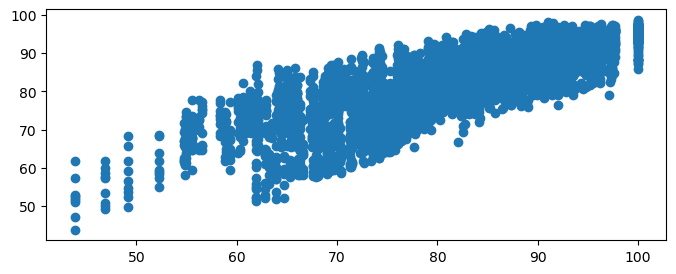

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.scatter(true, predictions)
plt.show()

Let's make a function so we can reuse this plotting logic for each evaluation run.

Executing EvaluationPhase: eval_train_set
  > Evaluating
    - Avg. sample loss = 35.2520
Executing EvaluationPhase: eval_val_set
  > Evaluating
    - Avg. sample loss = 26.0650
Executing EvaluationPhase: eval_test_set
  > Evaluating
    - Avg. sample loss = 62.4505


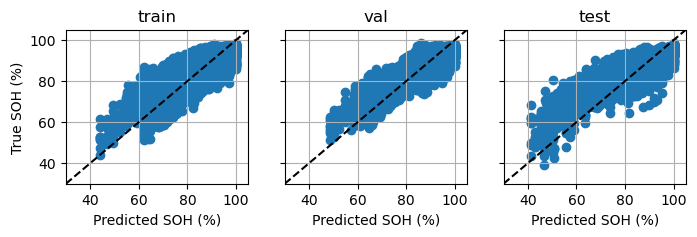

In [13]:
def plot_parity(pred, true, fig, ax):
    ax.scatter(true, pred)
    ax.axline((0,0), (1,1), color='black', linestyle='--')
    return fig, ax

eval_phases = [('train', eval_train_phase), ('val', eval_val_phase), ('test', eval_test_phase)]
fig, axes = plt.subplots(figsize=(8,2), ncols=3, sharex=True, sharey=True)
for i, (subset, phase) in enumerate(eval_phases):
    
    output = exp.run_evaluation_phase(phase)
    temp = charge_samples.get_samples_with_uuid(output['sample_uuid'])
    true = temp.get_all_targets(format=mml.DataFormat.NUMPY).reshape(-1)
    pred = convert_to_format(output['Regressor.output'], format=mml.DataFormat.NUMPY).reshape(-1)
    
    fig, axes[i] = plot_parity(pred, true, fig=fig, ax=axes[i])
    axes[i].set_xlabel("Predicted SOH (%)") 
    axes[i].set_title(subset) 
    axes[i].grid()

axes[0].set_ylabel("True SOH (%)") 
axes[0].set_xlim(30, 105)
axes[0].set_ylim(30, 105)
plt.show()

Not too bad for a simple model, but there's definitely room to improve. 
In the next notebook, we will explore the just how quickly will can iterate over experiment configurations with ModularML.

## Summary

This notebook demonstrated how to:

- Build a ModelGraph with PyTorch backends
- Define training and evaluation phases
- Manage end-to-end execution with the Experiment container
- Visualize model performance


This concludes the **03_training_and_evaluation.ipynb** notebook.

The next tutorial explain `Experiment` tracking and rapid iteration: *...coming soon*